In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import math
from matplotlib.collections import PatchCollection
from matplotlib import colors

In [10]:
info = pd.read_csv("data/env_info.csv")
#info['num_of_birds'][0]

## Episodes learning

In [3]:
#TODO: output a file with general info about the simulation so that we know the number of birds considered a priori
#plt.style.available
plt.style.use('ggplot')

def plot_episode():
    info = pd.read_csv("data/env_info.csv")
    num_birds=info['num_of_birds'][0]
    episode_lenght=info['episodes_length'][0]
    df = pd.read_csv("data/episode.csv")
    df["NormEndTime"] = df["EndTime"] / episode_lenght
    df["mean_norm_end"] = df["NormEndTime"] .rolling(100, min_periods=5).mean()
    #print(df)
    pred_train = df["PredatorTraining"]
    learner_change = np.where(np.roll(pred_train, -1) != pred_train)[0]
    ax = df.plot(x="Episode", y="mean_norm_end", kind="line", lw=0.5, legend=False, figsize=(16,9))
    ax.set_ylabel("EndTime")
    for i, x_l in enumerate(learner_change):
        if i%2 == 0:
            ax.axvline(x=x_l, color="red", linestyle='--', lw=1)
        else:
            ax.axvline(x=x_l, color="blue", linestyle='--', lw=1)

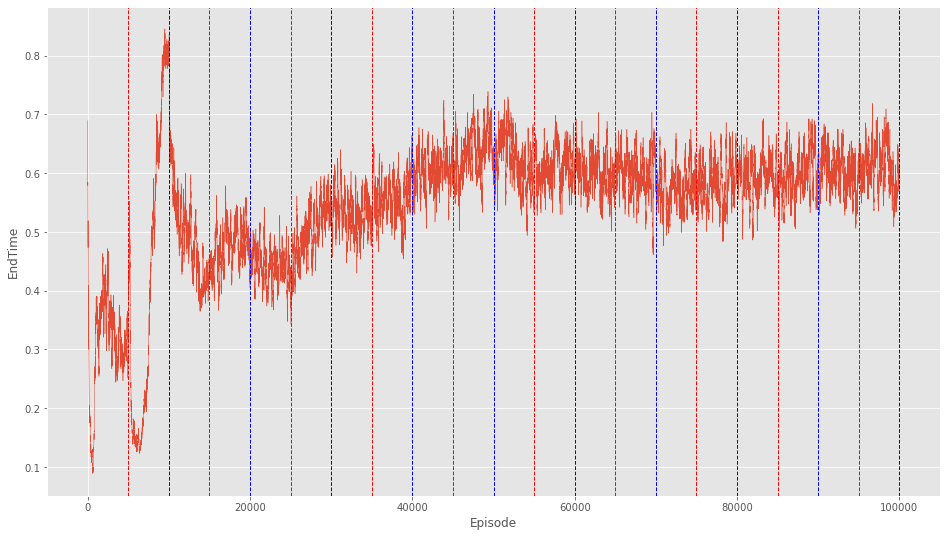

In [8]:
plot_episode()

## Various plots

In [38]:
def plot_first_instant(ep):
    info = pd.read_csv("data/env_info.csv")
    birds_num = info['num_of_birds'][0]
    df = pd.read_csv('data/pursuer_trajectory.csv')
    df = df[df["Episode"] == ep]
    df.reset_index(drop=True, inplace=True)
    x = []
    y = []
    cols = []
    for i in range(0,birds_num):
        x.append(df["x"+str(i)][0])
        y.append(df["y"+str(i)][0])
        if i==0:
            cols.append("red")
        else:
            cols.append("blue")


    fig, ax = plt.subplots()
    ax.scatter(x,y, c=cols)
    fig.savefig("plots/first_instant_"+str(ep)+".jpg")

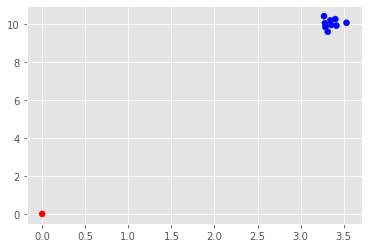

In [40]:
plot_first_instant(0)

In [13]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']